In this notebook, we are going to categorize reviews

In [1]:
import pandas as pd
import tensorflow as tf
import torch
import numpy as np
import time
import datetime
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from nltk.stem.porter import *
from nltk.stem import PorterStemmer
from snowballstemmer import TurkishStemmer

import jpype
from typing import List
from jpype import JClass, JString, getDefaultJVMPath, shutdownJVM, startJVM, java

import transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

from sklearn.metrics import f1_score, recall_score, precision_score, classification_report
from sklearn.preprocessing import LabelEncoder

In [2]:
data = pd.read_csv('7allV03.csv')
data.head()

,category,text
0,siyaset,3 milyon ile ön seçim vaadi mhp nin 10 olağan...
1,siyaset,mesut_yılmaz yüce_divan da ceza alabilirdi pr...
2,siyaset,disko lar kaldırılıyor başbakan_yardımcısı ar...
3,siyaset,sarıgül anayasa_mahkemesi ne gidiyor mustafa_...
4,siyaset,erdoğan idamın bir haklılık sebebi var demek ...


#### Quick Overview of Data

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4900 entries, 0 to 4899
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  4900 non-null   object
 1   text      4900 non-null   object
dtypes: object(2)
memory usage: 76.7+ KB


In [4]:
data['category'].value_counts()

siyaset       700
dunya         700
ekonomi       700
kultur        700
saglik        700
spor          700
teknoloji     700
Name: category, dtype: int64

In [5]:
print('There are', len(data['category'].value_counts()), 'categories')

There are 7 categories


C:\Users\burak\AppData\Roaming\Python\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='category', ylabel='count'>

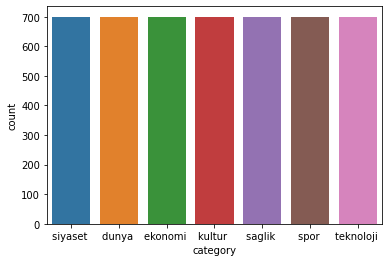

In [6]:
sns.countplot(data['category'])

## Preprocess

#### Data cleaning

-> Removing of punctuations, numbers, stopwords, urls etc.

-> Converting uppercase to lower

-> Tokenization

-> Lemmatization or Stemming

#### SENTENCE TOKENIZATION

In [7]:
data['text_sentence_count'] = data['text'].apply(sent_tokenize).tolist()
data['text_sentence_count'] = data['text_sentence_count'].apply(len)
data.head()

,category,text,text_sentence_count
0,siyaset,3 milyon ile ön seçim vaadi mhp nin 10 olağan...,1
1,siyaset,mesut_yılmaz yüce_divan da ceza alabilirdi pr...,1
2,siyaset,disko lar kaldırılıyor başbakan_yardımcısı ar...,1
3,siyaset,sarıgül anayasa_mahkemesi ne gidiyor mustafa_...,1
4,siyaset,erdoğan idamın bir haklılık sebebi var demek ...,1


In [8]:
data['text_sentence_count'].value_counts()

1     4349
2      434
3       70
4       18
5       16
6        5
22       2
7        2
23       1
8        1
10       1
12       1
Name: text_sentence_count, dtype: int64

In [9]:
# There is mostly no punctuations to end of the sentences, so remove that column.
data.drop('text_sentence_count', axis=1, inplace=True)

#### REMOVE UNNECESSARY CHARACTERS

In [10]:
# create a set of stopwords
stopwords_set = stopwords.words('turkish')
for line in open('turkish_stopwords.txt','r').readlines():
    stopwords_set.append(line.strip())
    
print(stopwords_set)

['acaba', 'ama', 'aslında', 'az', 'bazı', 'belki', 'biri', 'birkaç', 'birşey', 'biz', 'bu', 'çok', 'çünkü', 'da', 'daha', 'de', 'defa', 'diye', 'eğer', 'en', 'gibi', 'hem', 'hep', 'hepsi', 'her', 'hiç', 'için', 'ile', 'ise', 'kez', 'ki', 'kim', 'mı', 'mu', 'mü', 'nasıl', 'ne', 'neden', 'nerde', 'nerede', 'nereye', 'niçin', 'niye', 'o', 'sanki', 'şey', 'siz', 'şu', 'tüm', 've', 'veya', 'ya', 'yani', 'a', 'acaba', 'altÄ±', 'altmÄ±ÅŸ', 'ama', 'ancak', 'arada', 'artÄ±k', 'asla', 'aslÄ±nda', 'aslÄ±nda', 'ayrÄ±ca', 'az', 'bana', 'bazen', 'bazÄ±', 'bazÄ±larÄ±', 'belki', 'ben', 'benden', 'beni', 'benim', 'beri', 'beÅŸ', 'bile', 'bilhassa', 'bin', 'bir', 'biraz', 'birÃ§oÄŸu', 'birÃ§ok', 'biri', 'birisi', 'birkaÃ§', 'birÅŸey', 'biz', 'bizden', 'bize', 'bizi', 'bizim', 'bÃ¶yle', 'bÃ¶ylece', 'bu', 'buna', 'bunda', 'bundan', 'bunlar', 'bunlarÄ±', 'bunlarÄ±n', 'bunu', 'bunun', 'burada', 'bÃ¼tÃ¼n', 'Ã§oÄŸu', 'Ã§oÄŸunu', 'Ã§ok', 'Ã§Ã¼nkÃ¼', 'da', 'daha', 'dahi', 'dan', 'de', 'defa', 'deÄŸil', 'diÄŸer'

In [11]:
# create a set of punctuations
punctuation_set = string.punctuation
punctuation_set

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [12]:
# Check has some unnecessary words. Find if exists and count
re_urls = r'http\S+'
re_html = r'<.*?>'
re_digits = r'\d+'

print("Number of urls in tweets ", data['text'].str.count(re_urls).sum())
print("Number of html tag in tweets ", data['text'].str.count(re_html).sum())
print("Number of digits in tweets ", data['text'].str.count(re_digits).sum())

Number of urls in tweets  6
Number of html tag in tweets  1
Number of digits in tweets  49168


In [13]:
def clean(text):
    #lowercase operation
    text = text.lower()
    #remove urls
    text = re.sub(re_urls, '', text)
    #remove html
    text = re.sub(re_html, '', text)
    #remove digits
    text = re.sub(re_digits, '', text)
    #remove stop words 
    text = text.split()
    text = ' '.join([word for word in text if not word in stopwords_set])
    
    return text

In [14]:
def remove_punctuations(text):
    for punctuation in punctuation_set:
        text = text.replace(punctuation, ' ')
    return text

In [15]:
data['cleaned_text'] = data['text'].apply(lambda x: clean(x))

# CLEANING PUNTUATIONS PROCESS
data["cleaned_text"] = data['cleaned_text'].apply(remove_punctuations)

## CLEANING STOPWORDS PROCESS
data['cleaned_text'] = data['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords_set)]))

data.head()

,category,text,cleaned_text
0,siyaset,3 milyon ile ön seçim vaadi mhp nin 10 olağan...,ön seçim vaadi mhp olağan büyük kurultayı nda ...
1,siyaset,mesut_yılmaz yüce_divan da ceza alabilirdi pr...,mesut yılmaz yüce divan ceza alabilirdi prof d...
2,siyaset,disko lar kaldırılıyor başbakan_yardımcısı ar...,disko lar kaldırılıyor başbakan yardımcısı arı...
3,siyaset,sarıgül anayasa_mahkemesi ne gidiyor mustafa_...,sarıgül anayasa mahkemesi gidiyor mustafa sarı...
4,siyaset,erdoğan idamın bir haklılık sebebi var demek ...,erdoğan idamın haklılık sebebi demek yeri geld...


#### WORD TOKENIZATION

In [16]:
string_text = data['cleaned_text'].str
data['cleaned_text'] = string_text.translate(str.maketrans('', '', punctuation_set))
data['text_word'] = data['cleaned_text'].apply(word_tokenize).to_list()
data['text_word_count'] = data['text_word'].apply(len)

data.head()

,category,text,cleaned_text,text_word,text_word_count
0,siyaset,3 milyon ile ön seçim vaadi mhp nin 10 olağan...,ön seçim vaadi mhp olağan büyük kurultayı nda ...,"[ön, seçim, vaadi, mhp, olağan, büyük, kurulta...",719
1,siyaset,mesut_yılmaz yüce_divan da ceza alabilirdi pr...,mesut yılmaz yüce divan ceza alabilirdi prof d...,"[mesut, yılmaz, yüce, divan, ceza, alabilirdi,...",379
2,siyaset,disko lar kaldırılıyor başbakan_yardımcısı ar...,disko lar kaldırılıyor başbakan yardımcısı arı...,"[disko, lar, kaldırılıyor, başbakan, yardımcıs...",575
3,siyaset,sarıgül anayasa_mahkemesi ne gidiyor mustafa_...,sarıgül anayasa mahkemesi gidiyor mustafa sarı...,"[sarıgül, anayasa, mahkemesi, gidiyor, mustafa...",72
4,siyaset,erdoğan idamın bir haklılık sebebi var demek ...,erdoğan idamın haklılık sebebi demek yeri geld...,"[erdoğan, idamın, haklılık, sebebi, demek, yer...",167


#### LEMMA

In [17]:
ZEMBEREK_PATH = 'D:\zemberek-full_old.jar'
if jpype.isJVMStarted() is False:
        startJVM(getDefaultJVMPath(), '-ea', '-Djava.class.path=%s' % (ZEMBEREK_PATH))
TurkishMorphology = JClass('zemberek.morphology.TurkishMorphology')
morphology = TurkishMorphology.createWithDefaults()

In [18]:
def lemmatizer(data):
    lemma_words = []
    for text in data:
        lemma_word = str(morphology.analyzeAndDisambiguate(str(text)).bestAnalysis()[0].getLemmas()[0])
        lemma_words.append(lemma_word)
    text = ' '.join(lemma_words)
    return text

data['text_word_lem'] = data['text_word'].apply(lemmatizer)
data['text_word_stem_count'] = data['text_word_lem'].apply(len)

data.head()

,category,text,cleaned_text,text_word,text_word_count,text_word_lem,text_word_stem_count
0,siyaset,3 milyon ile ön seçim vaadi mhp nin 10 olağan...,ön seçim vaadi mhp olağan büyük kurultayı nda ...,"[ön, seçim, vaadi, mhp, olağan, büyük, kurulta...",719,ön seçim vaat mhp olağan büyük kurultay nda ko...,3993
1,siyaset,mesut_yılmaz yüce_divan da ceza alabilirdi pr...,mesut yılmaz yüce divan ceza alabilirdi prof d...,"[mesut, yılmaz, yüce, divan, ceza, alabilirdi,...",379,mesut yıl yüce divan ceza al prof dr sacit ada...,2069
2,siyaset,disko lar kaldırılıyor başbakan_yardımcısı ar...,disko lar kaldırılıyor başbakan yardımcısı arı...,"[disko, lar, kaldırılıyor, başbakan, yardımcıs...",575,disko UNK kaldır başbakan yardımcı arınç disko...,3351
3,siyaset,sarıgül anayasa_mahkemesi ne gidiyor mustafa_...,sarıgül anayasa mahkemesi gidiyor mustafa sarı...,"[sarıgül, anayasa, mahkemesi, gidiyor, mustafa...",72,sarıgül anayasa mahkemesi git mustafa sarıgül ...,501
4,siyaset,erdoğan idamın bir haklılık sebebi var demek ...,erdoğan idamın haklılık sebebi demek yeri geld...,"[erdoğan, idamın, haklılık, sebebi, demek, yer...",167,erdoğan idam hak sebep demek yer gel zaman ida...,959


Lastly we can remove the words whose length less than 3. Because usually means nothing

In [20]:
def remove_words(word):
    shortword = re.compile(r'\W*\b\w{1,3}\b')
    return shortword.sub('', word)

data['text_word_lem'] = data['text_word_lem'].apply(remove_words)
data['text_word_lem_count'] = data['text_word_lem'].apply(len) # calculate again the length of words

data.head()

,category,text,cleaned_text,text_word,text_word_count,text_word_lem,text_word_stem_count,text_word_lem_count
0,siyaset,3 milyon ile ön seçim vaadi mhp nin 10 olağan...,ön seçim vaadi mhp olağan büyük kurultayı nda ...,"[ön, seçim, vaadi, mhp, olağan, büyük, kurulta...",719,seçim vaat olağan büyük kurultay konuş genel ...,3221,3221
1,siyaset,mesut_yılmaz yüce_divan da ceza alabilirdi pr...,mesut yılmaz yüce divan ceza alabilirdi prof d...,"[mesut, yılmaz, yüce, divan, ceza, alabilirdi,...",379,mesut yüce divan ceza prof sacit adal isviçre ...,1660,1660
2,siyaset,disko lar kaldırılıyor başbakan_yardımcısı ar...,disko lar kaldırılıyor başbakan yardımcısı arı...,"[disko, lar, kaldırılıyor, başbakan, yardımcıs...",575,disko kaldır başbakan yardımcı arınç disko tab...,2813,2813
3,siyaset,sarıgül anayasa_mahkemesi ne gidiyor mustafa_...,sarıgül anayasa mahkemesi gidiyor mustafa sarı...,"[sarıgül, anayasa, mahkemesi, gidiyor, mustafa...",72,sarıgül anayasa mahkemesi mustafa sarıgül ilçe...,475,475
4,siyaset,erdoğan idamın bir haklılık sebebi var demek ...,erdoğan idamın haklılık sebebi demek yeri geld...,"[erdoğan, idamın, haklılık, sebebi, demek, yer...",167,erdoğan idam sebep demek zaman idam sebep kend...,805,805


<AxesSubplot:>

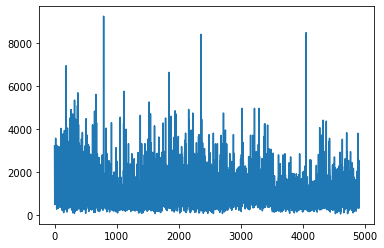

In [26]:
data['text_word_lem_count'].plot()

**BERT MODEL WILL BE IMPLEMENTED**